In [1]:
from crm.core import Network

In [2]:
import re
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split
random.seed(20)
torch.manual_seed(24)

In [3]:
from crm.utils import load_object, save_object, train

# Data

In [4]:
X_train, y_train  = load_object("data/sample5/X_train.dill"), load_object("data/sample5/y_train.dill")

In [5]:
X_test, y_test  = load_object("data/sample5/X_test.dill"), load_object("data/sample5/y_test.dill")

In [6]:
adj_list = load_object("data/sample5/adj_list.dill")

In [7]:
c = list(zip(X_train, y_train))
random.shuffle(c)
X_train, y_train = zip(*c)

# Training

In [8]:
num_neurons = len(adj_list)
n = Network(num_neurons, adj_list)

In [9]:
n.set_neuron_activation(num_neurons-2, lambda x : x, lambda x : 1)

In [10]:
n.set_neuron_activation(num_neurons-1, lambda x : x, lambda x : 1)

In [11]:
n.weights = load_object("data/sample5/weights_100.dill")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

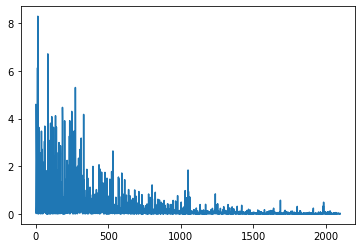

In [11]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
criterion = F.cross_entropy
losses = train(n, X_train, y_train, X_test, y_test, 3, optimizer, criterion)
plt.plot(losses)

In [12]:
train_correct = 0
for i in trange(len(X_train)):
    f_mapper = X_train[i]
    out = n.forward(f_mapper).reshape(1, -1)
    train_correct += 1 if torch.argmax(out)==y_train[i] else 0
    n.reset()
print("Train Accuracy: ", train_correct/len(X_train)*100)

  0%|          | 0/700 [00:00<?, ?it/s]

Train Accuracy:  100.0


In [13]:
test_correct = 0
for i in trange(len(X_test)):
    f_mapper = X_test[i]
    out = n.forward(f_mapper).reshape(1, -1)
    test_correct += 1 if torch.argmax(out)==y_test[i] else 0
    n.reset()
print("Test Accuracy: ", test_correct/len(X_test)*100)

  0%|          | 0/300 [00:00<?, ?it/s]

Test Accuracy:  99.66666666666667


In [14]:
train_correct, test_correct

(700, 299)

In [15]:
save_object(n.weights, "data/sample5/weights_100.dill")

# LRP

In [127]:
# https://github.com/dmitrysarov/LRP_decomposition/blob/master/notebooks/LRP_notebook_mnist.ipynb

In [83]:
max_layer = max([nn.layer for nn in n.neurons])
max_layer

3

In [126]:
# Train Set
counts = 0
total = 0
sorted_nids = None
with trange(len(y_train)) as t:
    for i in t:
        if y_train[i]==1:
            n.reset()
            n.forward(X_train[i])
            n.lrp(100., 1283)
            inc, sorted_nids=check_presence(network= n, n_ids = [756, 711, 633], percentile=0.01) #(Not including 27)
            counts+=inc
            total+=1
        t.set_postfix({"Counts": counts, "Total": total, "Ratio": counts/total})

  0%|          | 0/600 [00:00<?, ?it/s]

In [128]:
# 100% 600/600 [2:20:47<00:00, 16.50s/it, Counts=302, Total=351, Ratio=0.86] 1%

In [120]:
# Test Set
counts = 0
total = 0
sorted_nids = None
with trange(len(y_test)) as t:
    for i in t:
        if y_test[i]==1:
            n.reset()
            n.forward(X_test[i])
            n.lrp(100., 1283)
            inc, sorted_nids=check_presence(network= n, n_ids = [756, 711, 633], percentile=0.01) #(Not including 27)
            counts+=inc
            total+=1
        t.set_postfix({"Counts": counts, "Total": total, "Ratio": counts/total if total else None})

  0%|          | 0/100 [00:00<?, ?it/s]

In [124]:
# 100% 100/100 [21:56<00:00, 17.30s/it, Counts=46, Total=54, Ratio=0.852] 1%

In [121]:
# Test Set
counts = 0
total = 0
sorted_nids = None
with trange(len(y_test)) as t:
    for i in t:
        if y_test[i]==1:
            n.reset()
            n.forward(X_test[i])
            n.lrp(100., 1283)
            inc, sorted_nids=check_presence(network= n, n_ids = [756, 711, 633], percentile=0.03) #(Not including 27)
            counts+=inc
            total+=1
        t.set_postfix({"Counts": counts, "Total": total, "Ratio": counts/total if total else None})

  0%|          | 0/100 [00:00<?, ?it/s]

In [125]:
# 100% 100/100 [21:37<00:00, 17.27s/it, Counts=46, Total=54, Ratio=0.852] 3%

In [105]:
max_rel = -1
idx = -1
rels = []
for n_id in range(1284):
    if True:#1283 in n.neurons[n_id].successor_neurons or 1282 in n.neurons[n_id].successor_neurons:
        try:
            rels.append((n.neurons[n_id].relevance.item(), n_id, n.neurons[n_id].layer))
        except:
            pass
rels.sort(reverse=True)
rels[:15]

[(100.0, 1283, 3),
 (38.31831359863281, 22, 0),
 (20.276439666748047, 20, 0),
 (16.41777801513672, 23, 1),
 (15.62519645690918, 25, 1),
 (14.337860107421875, 21, 0),
 (8.297679901123047, 19, 0),
 (7.704973220825195, 97, 1),
 (6.702298641204834, 14, 0),
 (5.8988213539123535, 34, 1),
 (5.820578575134277, 15, 0),
 (5.541997909545898, 12, 0),
 (2.9191713333129883, 712, 2),
 (2.3127784729003906, 29, 1),
 (2.2477352619171143, 756, 2)]

In [114]:
# TrainSet: Top1%         Top3%
# TestSet: Top1%       Top3%
# Want to see: hasCar(X,Y), short(Y), closed(Y)

In [85]:
max_rel = -1
idx = -1
rels = []
for n_id in range(1284):
    if True:#1283 in n.neurons[n_id].successor_neurons or 1282 in n.neurons[n_id].successor_neurons:
        try:
            rels.append((n.neurons[n_id].relevance.item(), n_id, n.neurons[n_id].layer))
        except:
            pass
rels.sort(reverse=True)
rels[:15]

[(100.0, 1283, 3),
 (50.09611511230469, 22, 0),
 (28.143735885620117, 23, 1),
 (25.122875213623047, 21, 0),
 (11.22695541381836, 3, 0),
 (10.006945610046387, 18, 0),
 (7.728886127471924, 298, 1),
 (4.784719467163086, 25, 1),
 (3.5847561359405518, 712, 2),
 (3.547109842300415, 19, 0),
 (3.1040234565734863, 713, 2),
 (2.742990493774414, 757, 2),
 (2.4108364582061768, 632, 2),
 (2.3875539302825928, 859, 2),
 (2.3309028148651123, 29, 1)]

In [ ]:
max([n.neurons[i].layer for i in range(n.num_neurons)])

3

In [17]:
orig_output_neurons = []
orig_output_neurons_check= []
for gg in n.neurons:
    if gg.successor_neurons == [977, 978]:
        orig_output_neurons.append(gg.n_id)
    if gg.layer == 2:
        orig_output_neurons_check.append(gg.n_id)

In [18]:
y_train[0]

tensor(1)

In [19]:
len(orig_output_neurons), n.num_neurons

(750, 979)

In [20]:
zero_f_vals = [i for i in range(n.num_neurons) if X_train[0][i]==0]

In [21]:
len(zero_f_vals)

707

In [22]:
oo = 0
for i in range(num_neurons):
    if i not in zero_f_vals:
        oo+=n.neurons[i].relevance

In [23]:
n.reset()
n.forward(X_train[1]), y_train[1]

(tensor([[90.4348],
         [83.1681]], grad_fn=<StackBackward0>),
 tensor(0))

In [24]:
y_train[:20]

(tensor(1),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1))

In [25]:
n.neurons[978].value

tensor([83.1681], grad_fn=<MulBackward0>)

In [26]:
main_l = {i:0 for i in range(n.num_neurons)}
for i in trange((30)):
    if y_test[i]:
        n.reset()
        n.forward(X_test[i])
        n.lrp(torch.tensor(100.), 978)
        l = ([(n.neurons[i].relevance, i) for i in orig_output_neurons])
        for rel, idx in l:
            main_l[idx]+=rel
# main_l.sort(reverse=True)
# main_l[:10]

  0%|          | 0/30 [00:00<?, ?it/s]

In [27]:
rels = []
for k, v in (main_l.items()):
    rels.append((v, k+1))
rels.sort(reverse=True)

In [29]:
c = 0
real = 0
for i in range(len(y_test)):
    if y_test[i]:
        real+=1
        if X_test[i][326]:
            c+=1
c, real

(165, 165)

In [37]:
n.neurons[326].predeccesor_neurons

[977, 978]

In [28]:
rels[:10]

[(tensor([382.3938], grad_fn=<AddBackward0>), 327),
 (tensor([80.3215], grad_fn=<AddBackward0>), 935),
 (tensor([72.6319], grad_fn=<AddBackward0>), 510),
 (tensor([69.2016], grad_fn=<AddBackward0>), 372),
 (tensor([66.7294], grad_fn=<AddBackward0>), 641),
 (tensor([50.2880], grad_fn=<AddBackward0>), 703),
 (tensor([47.1415], grad_fn=<AddBackward0>), 791),
 (tensor([41.5360], grad_fn=<AddBackward0>), 412),
 (tensor([41.0481], grad_fn=<AddBackward0>), 879),
 (tensor([35.8847], grad_fn=<AddBackward0>), 371)]

In [38]:
len(set(orig_output_neurons)), len(set(orig_output_neurons_check))

(1237, 931)

In [41]:
n.neurons[24].successor_neurons, n.neurons[24].layer

([1282, 1283], 1)

# MLP

In [ ]:
input_neurons = []
for neuron in n.neurons:
    if len(neuron.predeccesor_neurons)==0:
        input_neurons.append(neuron.n_id)

In [92]:
input_neurons

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

In [110]:
class MLP(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(nn.Linear(inp_dim, 64), nn.ReLU(), nn.Linear(64, 32),nn.ReLU(), nn.Linear(32, 2))
    def forward(self, x):
        return self.mlp(x)

In [166]:
mlp = MLP(23, 2)

In [167]:
losses = []

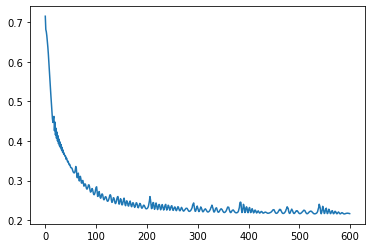

In [168]:
num_epochs = 600
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

for i in range(num_epochs):
    out = mlp(torch_dataset_inputs)
    loss = F.cross_entropy(out, torch_dataset_outputs)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
plt.plot(losses)
plt.show()

In [169]:
losses[-1]

0.21631726622581482

In [170]:
trained_out = mlp(torch_dataset_inputs)

In [178]:
(torch.argmax(trained_out, dim=1) == torch_dataset_outputs).sum()

tensor(613)

In [179]:
613/700

0.8757142857142857

In [181]:
torch.jit.script(mlp).save("torch_model_87_57.pt")

In [191]:
mlp.mlp[0]

Linear(in_features=23, out_features=64, bias=True)